# Linear Regression Vectorized

Vectorized Implementation of Linear Regression

In [45]:
from collections import namedtuple

Model = namedtuple('Model', ['w', 'b', 'dW', 'db', 'y_hats', 'dlosses', 'dy_hats', 'loss'])

class LinearRegression:
    def __init__(self, X, ys, W=None, b=0.0, learning_rate=0.001):
        # Initialize starting weights and biases
        (M,) = X.shape
        
        self.X, self.ys = X.reshape(1,M), ys
        self.learning_rate = learning_rate
        
        self.W = np.array([0.0]) if not W else W
        self.b = 0.0
        
    def forward_backward_prop(self):
        """Perform forward and backward prop over all training examples
        
        Returns loss and gradients
        
        """
        # Forward Pass (predictions)
        y_hats = self.W @ self.X + self.b

        # Loss
        losses = 0.5 * (y_hats-self.ys)**2
        loss = sum(losses) / M

        # Backpropagate to find dw and db
        dlosses = np.ones_like(losses)
        dy_hats = (y_hats-self.ys) * dlosses
        db = sum(dy_hats)
        dW = dy_hats @ self.X.T
        
        # Normalize by the number of training examples
        db /= M
        dW /= M
        
        return loss, dW, db
    
    def step(self):
        """Run one iteration of batch gradient descent"""
        
        loss, dW, db = self.forward_backward_prop()
        
        self.W -= self.learning_rate*dW
        self.b -= self.learning_rate*db 
        
        return self.W, self.b

## Create Synthetic Data

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


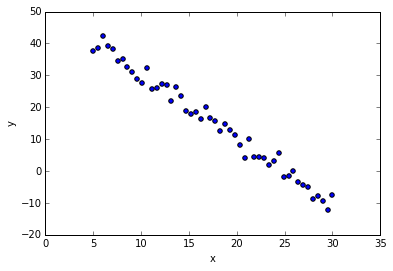

In [57]:
M = 50

X_train = np.linspace(5, 30, num=M)
w_true, b = np.array([-2.0]), 50

# Compute ys
noise_level = 2
ys_train = w_true[0]*X_train + b
ys_train = np.array([y + np.random.randn()*noise_level for y in ys_train])

pd.DataFrame({'x': X_train, 'y': ys_train}).plot(kind='scatter', x='x', y='y')

## Visualize the Model

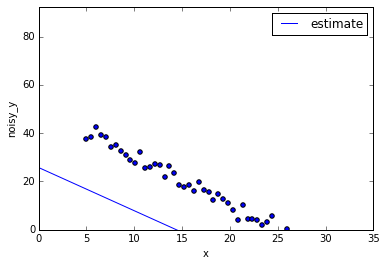

In [58]:
from ipywidgets import interact, fixed

lr = LinearRegression(X_train, ys_train)
def estimates(iters):
    for _ in range(iters):
        yield lr.step()
    
estimates = list(estimates(15000))

@interact(X=fixed(X_train), ys=fixed(ys_train), view_index=(0, len(estimates)), estimates=fixed(estimates))
def plot(X, ys, view_index, estimates):
    w, b = estimates[view_index]
    
    xs = np.linspace(0, 50)
    
    # Get data into suitable form for plotting
    df1 = pd.DataFrame({'x': X, 'noisy_y': ys})
    df2 = pd.DataFrame({'x': xs, 'estimate': w*xs + b})
    
    # Plot
    axes = df1.plot(kind='scatter', x='x', y='noisy_y')
    axes = df2.plot(ax=axes, x='x', y='estimate')
    
    axes.set_ylim(0,max(ys)+50)
    axes.set_xlim(0,max(X)+5)

In [280]:
estimate = lin_reg(X_train.reshape(1,M), ys=ys_train, learning_rate=0.005)
estimates = [next(estimate) for _ in range(100)]

df = pd.DataFrame(estimates, columns=Model._fields)